In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv


SHAP and LIME are Explainable AI techniques used to interpret black-box machine learning models. SHAP provides global and local explanations by assigning each feature a contribution value based on game theory, while LIME explains individual predictions by approximating the model locally using an interpretable model. Together, they enhance transparency, trust, and ethical deployment of AI models in sensitive domains like healthcare.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap
import lime
import lime.lime_tabular


Dataset Loading & Understanding

You begin by loading the Heart Disease dataset (heart.csv) using pandas.

Purpose:

To understand the structure of the dataset

To verify number of samples, features, and target variable

Key checks performed:

Dataset shape

Data types

Missing values

Distribution of the target variable (target)

✔ All features are numerical
✔ No preprocessing or encoding required

This confirms the dataset is ready for machine learning.

In [11]:
df = pd.read_csv("/kaggle/input/heart-disease-dataset/heart.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [14]:
df.shape

(1025, 14)

In [15]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target     

Feature–Target Separation

You split the dataset into:

Features (X) → all medical attributes (age, cp, thalach, etc.)

Target (y) → target column (0 = No Disease, 1 = Disease)

Why this is done:

Machine learning models learn patterns in features (X) to predict the target (y).

In [16]:
X = df.drop('target', axis=1)
y = df['target']


Train–Test Split

You divide the data into:

Training set (70%)

Testing set (30%)

Using:

random_state=42 → reproducibility

stratify=y → preserves class balance (important in healthcare)

Why this matters:

Prevents data leakage

Ensures fair evaluation

Mimics real-world unseen patient data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (717, 13)
Testing shape: (308, 13)


Random Forest Model Training

You use a Random Forest Classifier, an ensemble-based machine learning algorithm.

Why Random Forest:

Handles non-linear relationships

Reduces overfitting compared to single decision trees

High accuracy

Suitable for medical datasets

The model is trained using the training data (X_train, y_train).

In [19]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_classifier.fit(X_train, y_train)
print("✅ Random Forest trained successfully")

✅ Random Forest trained successfully


Model Evaluation

After training, predictions are made on the test set.

You evaluate the model using:

Accuracy

Precision

Recall

F1-score

Confusion Matrix

Why this step is critical:

Accuracy alone is not enough in healthcare

Recall is important to avoid missing diseased patients

Confusion matrix shows false positives & false negatives

In [20]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9805

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       150
           1       1.00      0.96      0.98       158

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



Feature Importance (Model-Level Interpretation)

Random Forest provides built-in feature importance scores.

You:

Rank features by importance

Visualize them using bar plots

What this tells you:

Which medical factors influence predictions the most

How the model prioritizes features globally

This is basic interpretability, but not enough for ethics.

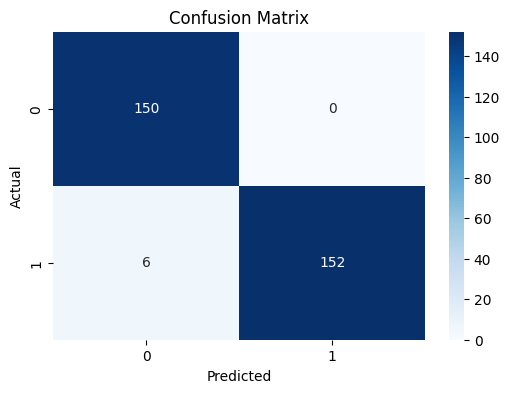

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Top 5 Important Features:


,Feature,Importance
2,cp,0.140129
7,thalach,0.131526
11,ca,0.116020
9,oldpeak,0.105527
12,thal,0.099114


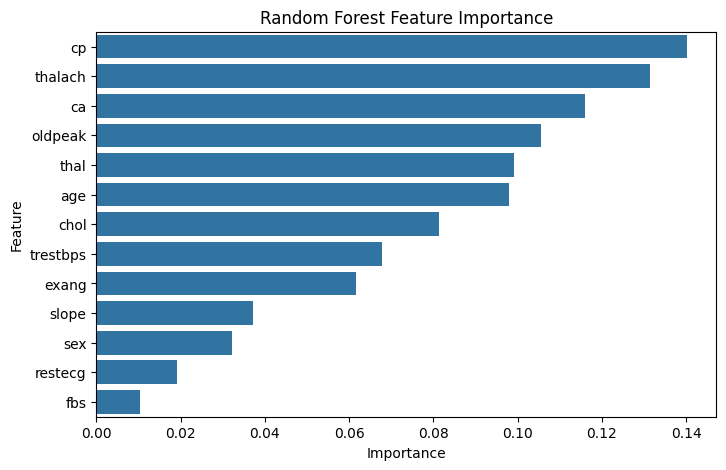

In [22]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 5 Important Features:")
display(feature_importances.head(5))

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Random Forest Feature Importance")
plt.show()


SHAP (SHapley Additive exPlanations) is used to explain the model globally.

You generate:

Bar plot

Shows top features by average impact

Beeswarm plot

Shows feature impact + direction (+/–)

Shows distribution across all samples

Why SHAP is important:

Based on game theory

Provides consistent and fair feature attribution

Explains how features contribute to predictions overall

This answers:

“How does the model behave in general?”

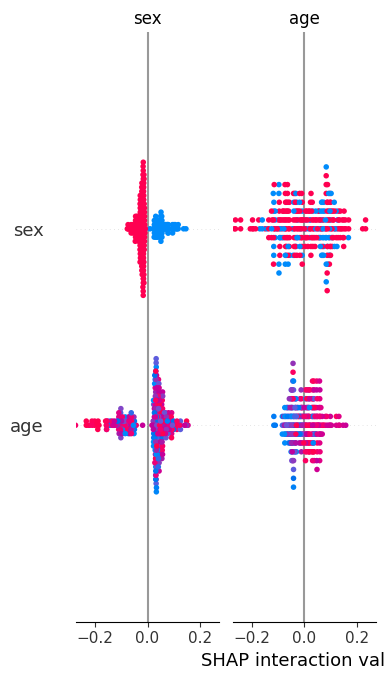

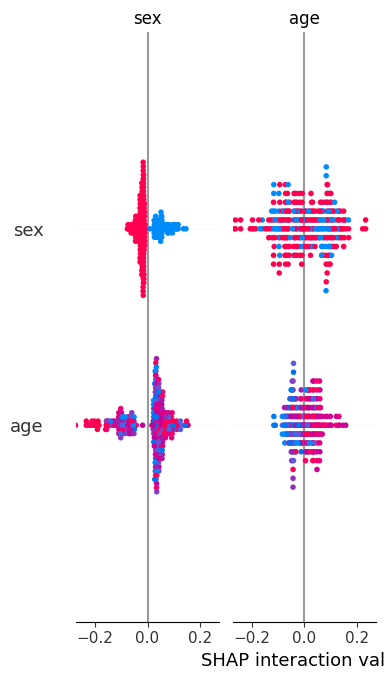

In [24]:
# Handle both SHAP formats safely
if isinstance(shap_values, list):
    shap_vals = shap_values[1]   # class = 1 (Disease)
else:
    shap_vals = shap_values      # already correct format

shap.summary_plot(shap_vals, X_test, plot_type="bar")
shap.summary_plot(shap_vals, X_test)


LIME (Local Interpretable Model-agnostic Explanations) is used to explain one prediction at a time.

What you do:

Define a prediction function (predict_proba_fn)

Initialize LimeTabularExplainer

Generate explanation for a single patient

What LIME provides:

Human-readable rules (e.g., oldpeak > 1.6)

Probability scores

Feature contribution table

LIME answers:

“Why did THIS patient get THIS prediction?”

In [26]:
# Prediction function for LIME
def predict_proba_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_train.columns)
    return rf_classifier.predict_proba(X_df)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Disease', 'Disease'],
    mode='classification',
    discretize_continuous=True
)

lime_exp = lime_explainer.explain_instance(
    data_row=instance.values[0],
    predict_fn=predict_proba_fn,
    num_features=10
)

lime_exp.show_in_notebook(show_table=True)


| Aspect           | SHAP           | LIME           |
| ---------------- | -------------- | -------------- |
| Scope            | Global + Local | Local only     |
| Stability        | High           | Moderate       |
| Interpretability | Strong         | Very intuitive |
| Ethics use       | Excellent      | Excellent      |


This project demonstrates that:

High-accuracy models can be black-box

****
SHAP and LIME improve trust and accountability

This aligns with Ethics in AI principles:

Transparency

Fairness

Accountability

Trustworthiness